### MTH 610 Model Constrained Optimization 1 (Homework 2)

##### Emily Bogle
##### 11/06/23

#### Problem 

Consider the boundary value problem (BVP) for a function $x:[0,1] \to \mathbb{R}$,
$$
\begin{cases}
-x''(t)+x^3(t)=u\\
(x(0)=0, \quad x(1)=0
\end{cases}
$$
where $u\in\mathbb{R}$ is a constant scalar parameter. In this assignment we want to find an optimal parameter value $u^*$ such that the solution $x(t)$ to the BVP minimizes the cost functional 
$$
J(x,u)=\frac{\omega}{2}|u|^2+\frac{1}{2}\int_0^1|x(t)-\overline{x}(t)|^2dt
$$
where $\overline{x}(t)$ is a given function (desired outcome/goal, measurement) and $\omega\geq 0$ is a specified fixed weight parameter. 

#### Part 1 (Optimality Conditions)

We know that 
$$
\delta J = \omega u \delta u +\int_0^1 (x(t)-\overline{x}(t))\delta x dt.
$$
Now, the variation in the model is given by the following:


$$
\begin{cases}
-\delta x'' + 3x^2\delta x = \delta u \\
\delta x(0)=0, \quad \delta x(1)=0
\end{cases}
$$

We will take the inner product with the lambda function to get,
$$
\int_0^1-\delta x''\lambda + 3x^2\delta x \lambda dt = \int_0^1\delta u \lambda dt \\
\implies -\delta x'\lambda |_0^1 +\int_0^1 \delta x'\lambda' + 3x^2\delta x \lambda dt = \int_0^1 \delta u dt\\
\implies (-\delta x'\lambda + \delta x \lambda')|_0^1 + \int_0^1 -\lambda''\delta x + 3x^2\lambda \delta x dt = \int_0^1 \delta u \lambda dt \\
\implies -\delta x'(1) \lambda (1) + \delta x(1) \lambda' (1) - (-\delta x'(0) \lambda (0) + \delta x(0) \lambda' (0)) + \int_0^1 -\lambda'' \delta (x) + 3x^2 \lambda \delta (x) dt = \int_0^1 \delta u \lambda dt
$$

Therfore, we define $\lambda (t)$ solution to the BVP (adjoint model) as the following:
$$
\begin{cases}
-\lambda''(t) +3(x(t))^2 \lambda(t) = x(t) - \overline{x}(t) \\
\lambda (0) =0, \quad \lambda(1)=0
\end{cases}
$$

With this definition of $\lambda (t)$ we obtain $\delta J$ in terms of $\delta u$,
$$
\begin{align*}
\delta J &= \omega u \delta u +\int_0^1 \delta u \lambda(t) dt\\
&= [\omega u + \int_0^1 \lambda(t) dt]\delta u
\end{align*}
$$

Now, the optimality condition ($\nabla_u J=0$) is given by,
$$
\omega u + \int_0^1 \lambda(t) dt =0
$$

Therefore our first order optimality conditions (Euler Lagrange Equations) for the minmization of the cost functional subject the the BVP constraint are given by,
$$
\begin{cases}
-x''(t)+x^3(t)=u\\
-\lambda''(t) + 3(x(t))^2\lambda(t) = x(t)-\overline{x}(x)\\
x(0)=0, \quad x(1)=0\\
\lambda(0)=0, \quad \lambda(1)=0
\end{cases}
$$
with the optimality condition:
$$
\omega u +\int_0^1 \lambda(t)dt =0
$$
where we know $\nabla_u J = \omega u +\int_0^1 \lambda(t)dt$.

#### Part 2 (Use Method of Choice to Estimate $u^*$)

With the given optimality system we can discretize and then optimize. After discretizing the two systems of PDEs both become a system of nonlinear equations to solve. Furthermore, in this way we can start wtih an initial $u$ value, and then from that we can find $x$ givne the model BVP constraint, and then once we have $x$ we can solve for $\lambda$ using the adjoint model. We will utilize scipy.optimize.fsolve to solve the sytem of nonlinear equations. Then we will cycle through this process in doing steepest descent iterations on $\nabla_u J$. 

A discrete version to the original BVP is obtained by considering a uniform partition of the interval $[0,1]$ with nodes $\{t_i:i=0:n+1\}$ at an increment $h=\frac{1}{N+1}$,
$$
0=t_0<t_1<\dots<t_N<t_{N+1}=1, \quad t_i=i*h \textrm{ for } i=0:N+1
$$
and an approximation for the second order derivative using a finite difference formula is 
$$
x''(t_i)\approx\frac{x(t_{i+1})-2x(t_i)+x(t_{i-1})}{h^2}, \quad i=1:N
$$

Therefore a discrete version of the BVP is given by,
$$
\begin{cases}
\frac{x_{i+1}-2x_i+x_{i-1}}{h^2} + x^3_{i} = u_i, \quad i=1:N\\
x_0=0, \quad x_{N+1}=0
\end{cases}
$$
where $x_i\approx x(t_i), \quad i=1:N$.

We can write this sytem of equations in matrix vector format,
$$
\mathbf{A}\mathbf{x}+\mathbf{G}(\mathbf{x})=u\mathbf{1_N}
$$
where $u \in \mathbb{R}$ is a scalar, $\mathbf{1_N}\in \mathbb{R}^N$ is the constant vector of 1's, $\mathbf{A}\in \mathbb{R}^{N*N}$ is a scaled tridaigonal matix with 2 on the main diagonal and -1 on the neighboring minor diagonals and the scaling constant is given by $\frac{1}{h^2}$, and $\mathbf{G}:\mathbb{R}^N\to\mathbb{R}^N$ is a vector valued funcition with $x_i^3$ in each component. 

Similarly after discretizing $\lambda$ in time, we can write the other system of equations ivolving $\lambda$ in matrix vector format,
$$
\mathbf{A}\mathbf{\lambda}+\mathbf{F}(\mathbf{x,\lambda})= \mathbf{x} - \mathbf{\overline{x}}
$$
where $\mathbf{F}:\mathbb{R}^N\to\mathbb{R}^N$ is a vector valued funcition with $3x_i^2*\lambda_i$ in each component, and $\mathbf{\overline{x}}$ is a time discretized vector with components based on the given goal function provided.

In [31]:
#Import needed packages

import matplotlib.pyplot as plt
import numpy as np
import scipy
import sympy
from scipy.optimize import fsolve

In [1]:
def homework2(omega, uguess, step_size):
    # Define constants
    N=100
    h=1/N
    maxiter = 100000
    tol = 1e-8
    iteration = 0

    # Define A (discrete Laplace) matrix
    main_diag = 2 * np.eye(N+1)
    minor_diags = -1 * (np.eye(N+1, k=-1) + np.eye(N+1, k=1))
    A = 1/(h*h) * (main_diag + minor_diags)

    # Create initial guess vector u for fsolve, and initlial vectors needed to define xbar vector
    u_guess = uguess
    u_guess_vect = u_guess * np.ones(N+1)
    t_nodes = np.zeros(N+1)
    x_bar = np.zeros(N+1)
    uplot = np.zeros(N+1)

    # Create xbar vector based off xbar(t) = sin(pi*t)
    def xbar(t):
        return np.sin(np.pi * t)

    for i in range(N+1):
        t_nodes[i] = i*h
        x_bar[i] = xbar(t_nodes[i])

    # Create initial guess vector x for fsolve with 0 boundary conditions
    x_guess = np.zeros(N+1)
    x_guess[0] = 0
    x_guess[-1] = 0

    # Create initial guess vector lambda for fsolve with 0 boundary conditions
    lamb_guess = np.zeros(N+1)
    lamb_guess[0] = 0
    lamb_guess[-1] = 0

    # Define nonlinear system of equations for x BVP to find roots of using fsolve
    def xequation(x, A, u):
        return A @ x + x**3 - u

    # Define nonlinear system of equations for lambda BVP to find roots of using fsolve
    def lambequation(lamb, A, x, xbar):
        return A @ lamb + 3*(x**2) * lamb - x + xbar

    # Use fsolve to find approximate solution of x BVP
    resultx = fsolve(xequation, x_guess, args=(A, u_guess_vect), xtol=1e-10)

    # Use fsolve to find approximate solution of lambda BVP
    resultlamb = fsolve(lambequation, lamb_guess, args=(A, resultx, x_bar), xtol=1e-10)

    # Define steepest descent move for new u_guess value
    def steepest_descent_move(gradient, u_guess, step_size):
        return u_guess - (step_size * gradient)

    # Define gradient with respect to u of the cost function J
    def gradju(omega, u_guess, resultlamb):
        integral = np.trapz(resultlamb, dx=1/len(resultlamb))
        return omega * u_guess + integral
    
    # Define reduced cost function value after you have x based on choice of u
    def redcost(u_guess, resultx, omega, x_bar):
        error2 = (resultx - x_bar)**2
        integral = np.trapz(error2, dx=1/len(x_bar))
        return (omega/2)*(u**2)+(1/2)*integral
    
    # Find first gradient value
    gradient = gradju(omega, u_guess, resultlamb)

    # Steepest descent using gradient of J with respect to u
    while (iteration < maxiter):
        gradient_mag = np.abs(gradju(omega, u_guess, resultlamb))
        
        # Output
        if gradient_mag < tol:
            print(f"Omega:", omega)
            print(f"Converged after {iteration + 1} iterations.")
            print(f"Optimal u value:", u_guess)
            break

        else:
            u_guess = steepest_descent_move(gradient, u_guess, step_size)
            u_guess_vect = u_guess * np.ones(N+1)
            resultx = fsolve(xequation, x_guess, args=(A, u_guess_vect), xtol=1e-10)
            resultlamb = fsolve(lambequation, lamb_guess, args=(A, resultx, x_bar), xtol=1e-10)
            gradient = gradju(omega, u_guess, resultlamb)

            iteration += 1

    if iteration == maxiter:
        print("Maximum iterations reached without convergence.")
        
    else: 
        # Plot x funiton in comparison to xbar funciton at optimality
        x = np.arange(len(x_bar))
        plt.plot(x, x_bar, label='x_bar', marker='o')
        plt.plot(x, resultx, label='x', marker='x')
        plt.xlabel('t')
        plt.ylabel('x function values')
        plt.title(f'x function fit (at optimality) with omega: {omega}')
        plt.legend()
        plt.show()
        
        # Plot lambda influence fucntion at optimality
        plt.plot(x, resultlamb, marker='o')
        plt.xlabel('t')
        plt.ylabel('lambda function values')
        plt.title(f'influence function lambda values (at optimality) with omega: {omega}')
        plt.show()
        
        # Create reduced cost function dependent upon u values
        u_vals = np.zeros(N+1)
        startu = u_guess - 10
        
        for i in range(N+1):
            u_vals[i] = startu + (i*(20/N))
        
        x_guess = np.zeros(N+1)
        x_guess[0] = 0
        x_guess[-1] = 0
        
        redcosval = []
        for i in range(N+1):
            uvalvect = u_vals[i]*np.ones(N+1)
            solvex = fsolve(xequation, x_guess, args=(A, uvalvect), xtol=1e-10)
            err = (solvex - x_bar)**2
            integral = np.trapz(err, dx=1/len(x_bar))
            redcosval.append(0.5 * omega * u_vals[i]**2 + 0.5 * integral)
        
        # Plot reduced cost function to verify optimal u value
        plt.plot(u_vals, redcosval, marker='o')
        plt.xlabel('u')
        plt.ylabel('reduced cost function value')
        plt.title(f'reduced cost function in terms of u with omega: {omega}')
        plt.show()

#### Part 2 & 3 (Optimal $u^*$ / Plots / Verification)

Omega: 1
Converged after 1551 iterations.
Optimal u value: 0.06640985740679824


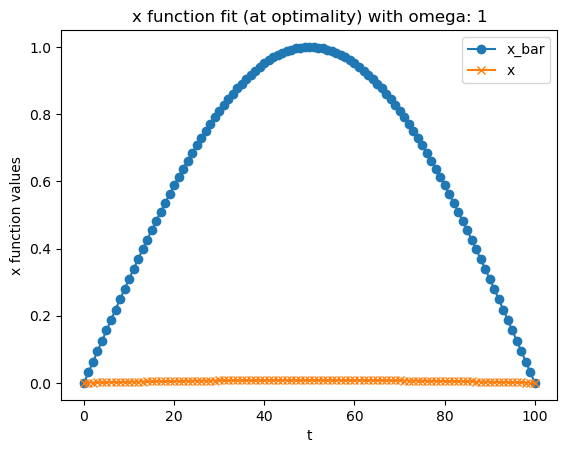

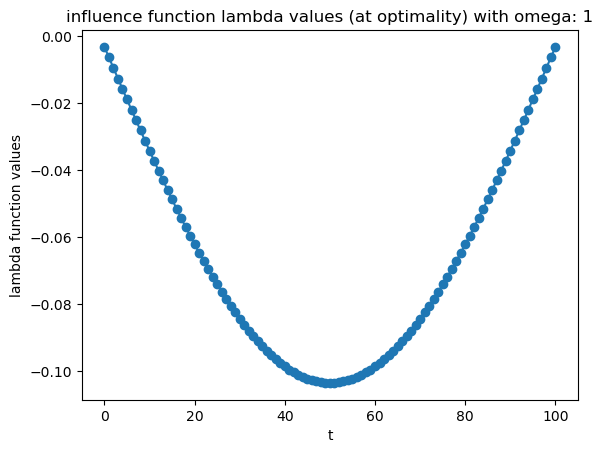

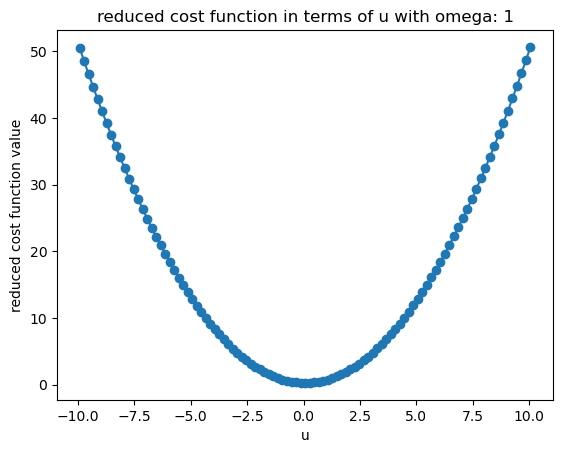

In [101]:
homework2(1, 0, 0.01)

Omega: 1e-06
Converged after 2444 iterations.
Optimal u value: 7.89500139828344


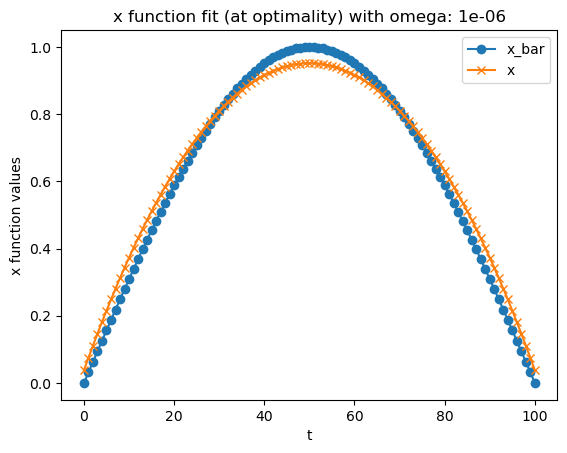

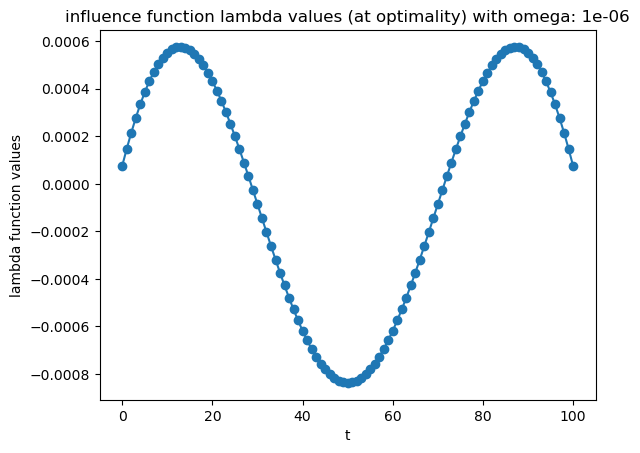

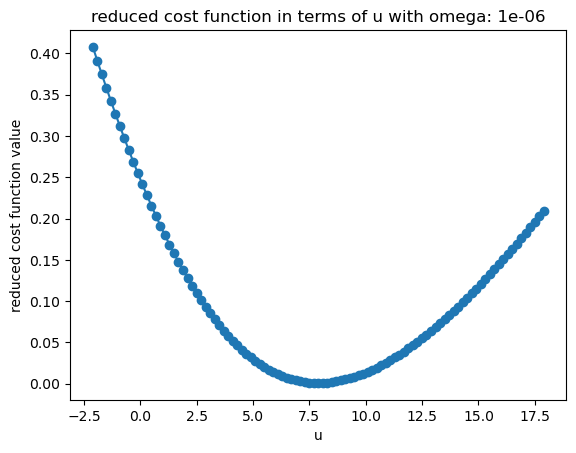

In [102]:
homework2(1e-6, 0, 1.0)